In this file we run a sentence classifier using Word2Vec in Python. All data originates from Kaggle and can be found here: https://www.kaggle.com/datasets/yashdogra/nlpdataset

In [1]:
import gensim

In [2]:
gensim

<module 'gensim' from 'C:\\Users\\owenc\\anaconda3\\Lib\\site-packages\\gensim\\__init__.py'>

This is a Python module containing the implementation

In [3]:
gensim.models.word2vec

<module 'gensim.models.word2vec' from 'C:\\Users\\owenc\\anaconda3\\Lib\\site-packages\\gensim\\models\\word2vec.py'>

In [4]:
gensim.models.Word2Vec

gensim.models.word2vec.Word2Vec

In [5]:
from gensim.models import Word2Vec

In [7]:
import nltk

These commands allow the kaggle database to be downloaded remotely. They are commented out in this case as we have already downloaded the data.

In [15]:
# import kagglehub

In [8]:
# !pip install kaggle

In [9]:
#!pip install kagglehub

In [10]:
# path = kagglehub.dataset_download("yashdogra/nlpdataset")

In [11]:
# path

In [12]:
# print("Path to dataset files:",path)

There are five such files, each of comprises a tweet or similar message about the COVID-19 pandemic. There are exactly 689 tweets in each file (687 in the fourth one). However, we will not use the fourth one as it does not include label data.

In [13]:
import pandas as pd

Now we read in each file individually

In [32]:
df1 = pd.read_excel('labelled sentences(1).xlsx', sheet_name='labelled sentences',header=0)
df2 = pd.read_excel('labelled sentences(2).xlsx', sheet_name='labelled sentences',header=0)
df3 = pd.read_excel('labelled sentences(3).xlsx', sheet_name='labelled sentences',header=0)
df5 = pd.read_excel('labelled sentences(5).xlsx', sheet_name='labelled sentences',header=0)

In [33]:
df1, df2, df3, df5

(                                             Sentences  Label
 0    UN Humanitarian Chief Mark Lowcock today relea...      1
 1    The announcement came as the World Health Orga...      0
 2    The WHO has said there is still a chance of co...      1
 3    There are now cases linked to Iran in Bahrain,...      1
 4    Extensive testing in clinical trials has confi...      1
 ..                                                 ...    ...
 684  In November 2021, one stringent regulatory aut...      1
 685  Trials in children as young as age 3 years wer...      1
 686  Covaxin, an adjuvanted inactivated vaccine dev...      1
 687  The Indian regulatory authorities have given a...      1
 688  Several COVID-19 vaccines are undergoing trial...      1
 
 [689 rows x 2 columns],
                                              Sentences  Label
 0    UN Humanitarian Chief Mark Lowcock today relea...      1
 1    The announcement came as the World Health Orga...      0
 2    The WHO has said there

This data set is a series of 689 historical tweets about the response to the COVID-19 pandemic, obtained from Kaggle. 

We remove all punctuation to prevent parsing issues, except the hyphen. Then we parse each sentence into words.

In [25]:
def words(sentence): #split a sentence into words
    lettersandnumbers="abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890-"
    answer=[]
    sim = ""
    for word in sentence.split(" "):
        for letter in word:
            if letter in lettersandnumbers:
                sim=sim+letter
        answer.append(sim)
        sim=""
    return answer
    

Quick Test

In [26]:
words("The quick br3own fox jumps over the laaazy dawg and #blessed is Dr. O'Hara.")

['The',
 'quick',
 'br3own',
 'fox',
 'jumps',
 'over',
 'the',
 'laaazy',
 'dawg',
 'and',
 'blessed',
 'is',
 'Dr',
 'OHara']

This works as planned. This allows the words of a sentence to be considered at face value (a more advanced algorithm may include punctuation).

Now to convert word lists back into sentences.

In [27]:
def sentencize(w):
    return ' '.join(w)

In [28]:
sentencize((words("The quick br3own fox jumps over the laaazy dawg and #blessed is Dr. O'Hara.")))

'The quick br3own fox jumps over the laaazy dawg and blessed is Dr OHara'

In [29]:
df1+df2

,Sentences,Label
0,UN Humanitarian Chief Mark Lowcock today relea...,2
1,The announcement came as the World Health Orga...,0
2,The WHO has said there is still a chance of co...,2
3,"There are now cases linked to Iran in Bahrain,...",2
4,Extensive testing in clinical trials has confi...,2
...,...,...
684,"In November 2021, one stringent regulatory aut...",2
685,Trials in children as young as age 3 years wer...,2
686,"Covaxin, an adjuvanted inactivated vaccine dev...",2
687,The Indian regulatory authorities have given a...,2


In [38]:
df=pd.concat([df1,df2,df3,df5])

We develop a model by cross-validation. Due to working with individual sentences, we will use CBOW (continuous bag of words). We will split our data set into 4 parts, each of which corresponds to one of the 4 equally sized datasets. For each cross-validation step, we will analyze the other three datasets as (fittingly) a continuous bag of words, and use it to develop a model that we test on the fourth dataset.

In [39]:
def crossvalidate(trainset,testset):
    train_sentences = trainset['Sentences']
    test_sentences=testset['Sentences']
    trained=[]
    tested=[]
    for i in test_sentences:
        tested.append(words(i))
    for i in train_sentences:
        trained.append(words(i))
    model = gensim.models.Word2Vec(trained, min_count=1,
                                vector_size=50, window=5) #this generates a neural CBOW model
    return model, tested

In [41]:
(model1,test1)=crossvalidate(pd.concat([df2,df3,df5]),df1)
(model2,test2)=crossvalidate(pd.concat([df1,df3,df5]),df2)
(model3,test3)=crossvalidate(pd.concat([df1,df2,df5]),df3)
(model5,test5)=crossvalidate(pd.concat([df1,df2,df3]),df5)

This creates our cross-validation models, each tested on a different corpus.

In [43]:
model1.wv.similarity("efforts","vaccine")

0.99843615

This function is necessary as not every possible word appears in the corpus! If it does not appear we set the similarity to 0.

In [44]:
def similarity_check(m, w1, w2):
    try:
       p= m.wv.similarity(w1,w2)
    except KeyError:
        return 0
    else:
        return p
        

In [45]:
similarity_check(model1, 'fish','vaccine')

0

We are now ready to give a simple transformer model. This is meant to measure general relevance of the tweet.
The value returned is the average cosine distance, using CBOW, between each word in the sentence that appears in the corpus and the word "coronavirus".
This is generally going to be a value between 0 and 1. If a word does not appear in the corpus we assign it a value of 0, since that liokely indicates it is not particularly relevant to the pandemic (though exceptions exist!)

In [50]:
def covid_sentence_analyze(sentence, mod, wrd):
    avg=0
    n=0
    for word in words(sentence):
        a = similarity_check(mod, wrd, word)
        avg+=a
        n+=1
    return avg/n

In [51]:
covid_sentence_analyze("The quick brown vaccine jumps over the lazy quarantined person.", model1, "coronavirus")

0.49762266874313354

This is a transformer model. The word "coronavirus" was chosen as it is somewhat neutral word that is relevant to all tweets. A jumble of random letters would like give 0, while the word "coronavirus" repeated over and over again gives 1. 

Let us test this three more times. First, on an actual sentence in data set 1.

In [52]:
df1['Sentences'][99]

'Most health systems are facing challenges of increased demand for care of people with COVID-19, compounded by fear, misinformation and limitations on movement that disrupt the delivery of health care for all conditions.'

In [53]:
covid_sentence_analyze(_,model1,'coronavirus')

0.9833082538662534

As you can see, this is a much higher value!

Next, we will test it on something completely unrelated to COVID.

In [54]:
covid_sentence_analyze("I have this thing where I get older but just never wiser, midnights become my afternoons",model1,'coronavirus')

0.6859035305678844

You may be wondering why this is higher than the first sentence. This likely stems from very simple words like "I". This can be circumvented by only considering words of a given minimum length or excluding words from a certain set of trivial words.

In [55]:
covid_sentence_analyze("fetch coronavirus fetch coronavirus fetch coronavirus fetch coronavirus fetch coronavirus",model1,'coronavirus')

0.5

No surprise here -- since "fetch" is not in the corpus, it gives a similarity of 0, while the similarity of any word to itself is 1.

One more test: typos. This sentence will consist of 12 different misprints of the word "coronavirus." These data sentences willc ertainly contain few typographyical errors, so it is worth looking into.

In [56]:
covid_sentence_analyze("cornavirus coranovirus coronavisur coronvairus oronavirus corvinarius coronavirum corona-virus coronavir4us coronavirys voronavirqs curinavoros",model1,'coronavirus')

0.0

None of these words appear in the corpus. Thus, unfortunately, the text analysis here is limited to correctly spelled words. This is one of a number of limitations that can be refined with a more advanced model/

In [58]:
list1=[]
for i in df1['Sentences']:
    list1.append(covid_sentence_analyze(i,model1,'coronavirus'))
list2=[]
for i in df2['Sentences']:
    list2.append(covid_sentence_analyze(i,model2,'coronavirus'))
list3=[]
for i in df3['Sentences']:
    list3.append(covid_sentence_analyze(i,model3,'coronavirus'))
list5=[]
for i in df5['Sentences']:
    list5.append(covid_sentence_analyze(i,model5,'coronavirus'))

In [59]:
list1

[0.9918293219346267,
 0.9314588865748158,
 0.9833347916603088,
 0.9899636529110096,
 0.9557418070341411,
 0.9868485894468095,
 0.9851040144761404,
 0.9923541854929041,
 0.9922227106596294,
 0.9902730411953397,
 0.989372360078912,
 0.9901382940156119,
 0.9912685884369744,
 0.9798416327685118,
 0.9808306523731777,
 0.97682491729134,
 0.9900524399497292,
 0.991354700922966,
 0.9908904052795248,
 0.9928332478911789,
 0.9944034162908792,
 0.994418047941648,
 0.985515229842242,
 0.9888930728561,
 0.9917347964487577,
 0.9624028980731965,
 0.9828104533647236,
 0.9828967533328317,
 0.9847372873076077,
 0.987170044864927,
 0.9917025001425492,
 0.9737631437324342,
 0.9882435904608833,
 0.9934102462397681,
 0.985252064817092,
 0.9923803333578438,
 0.9869625456631184,
 0.9883957423947074,
 0.9915648290985509,
 0.9900664715539842,
 0.9935189651118385,
 0.9916730665025257,
 0.9858129437153156,
 0.9918594316199973,
 0.9930286837178607,
 0.9712062440812588,
 0.9871252266069254,
 0.9960445868117469,
 0.

In [60]:
list2

[0.9939341430480664,
 0.9569878445731269,
 0.9723273329436779,
 0.99134361743927,
 0.9867445575563532,
 0.989849779340956,
 0.9856688141822815,
 0.9871433134432193,
 0.9927898551288404,
 0.9899784286816915,
 0.9876320989508378,
 0.9893464429037911,
 0.9908213747872247,
 0.954082153737545,
 0.9694866765113104,
 0.9463080912828445,
 0.991327318278226,
 0.9940893083810807,
 0.9833316815660355,
 0.9909913164597971,
 0.9946539718657732,
 0.988358538884383,
 0.9883299329701591,
 0.9759384127039659,
 0.9904549456479257,
 0.8690190696716309,
 0.9867340765501323,
 0.9816864647648551,
 0.9803245417002974,
 0.9893610371010644,
 0.9898025801307276,
 0.9436618495909941,
 0.9839951091342503,
 0.994231833351983,
 0.9902407702277688,
 0.9914236150938889,
 0.986618172377348,
 0.9923443360762163,
 0.9908198808368883,
 0.9824810666697366,
 0.9919583863682218,
 0.9891768807456607,
 0.9762474436026353,
 0.9933221583013181,
 0.9893895637157352,
 0.9904416815230721,
 0.9900608671208223,
 0.9954824915954045,


In [61]:
list3

[0.9935098978189322,
 0.9330143266254001,
 0.9786546796560287,
 0.9898292907962093,
 0.9794175467993084,
 0.9915847116046481,
 0.9864814758300782,
 0.9779812494913737,
 0.9933583642307081,
 0.9893949111302693,
 0.9888369786111932,
 0.9906467573983329,
 0.9912714494599236,
 0.9568778295069933,
 0.9737039605776469,
 0.9623795355621138,
 0.9890403991395776,
 0.9959306478500366,
 0.9856155565444459,
 0.9920920155666493,
 0.9934836141765118,
 0.9920358268114237,
 0.9867808327955359,
 0.9822651775259721,
 0.993459263391662,
 0.9026076202094555,
 0.9853658080101013,
 0.9858591773293235,
 0.9843479045506182,
 0.9919072538614273,
 0.9868260120090685,
 0.9498300701379776,
 0.98975963195165,
 0.9922192659642961,
 0.9881856406436247,
 0.9930960248256552,
 0.9923734813928604,
 0.9908645302057266,
 0.9929976369205274,
 0.985435297091802,
 0.9931907090875838,
 0.9898336444582257,
 0.9729064909311441,
 0.9937731822331747,
 0.9894588243129642,
 0.9536815411166141,
 0.9920526805023352,
 0.99534732103347

In [63]:
list5

[0.9923288409526532,
 0.972177783648173,
 0.9881680920720101,
 0.9922915851628339,
 0.9811541500844454,
 0.9894035822815366,
 0.4936131139596303,
 0.9812685538221289,
 0.9904462695121765,
 0.9894685202174717,
 0.9899706213097823,
 0.9899087071418762,
 0.9926013913419511,
 0.9749452862888575,
 0.9697276070004418,
 0.9872540172777677,
 0.9908457886088978,
 0.9955886423587799,
 0.9885083272102031,
 0.9872766269577874,
 0.9951705224812031,
 0.9936951375924624,
 0.9866907000541687,
 0.9808438514408312,
 0.9931800124938028,
 0.9790825581550598,
 0.9918696723486248,
 0.9829793436960741,
 0.9838145313591793,
 0.9876511437552316,
 0.9929647790758234,
 0.9625280359316439,
 0.9828130417399936,
 0.9919563664330376,
 0.9885996545062345,
 0.9936038810631325,
 0.9909872934222221,
 0.989861480214379,
 0.9907465483012953,
 0.9882410977567945,
 0.9921980897585551,
 0.9919755771046593,
 0.9726912906536689,
 0.9934598935974969,
 0.9898269439852515,
 0.9812248976607072,
 0.9905808518330256,
 0.995701958026

We finally list the actual similarities of each tweet to its training set. Since these tweets are all about the same topic, this is very close to 1. Outliers can occur if there are unique words in certain tweets, perhaps due to typos. The 7th entry in list 5 is suspicious; checking the data this appears to be a misprint; this algorithm can quickly identify noise in the data.

END OF TASK 1

START OF TASK 2

We will classify each sentence into sixteen classes. We will do so with four numerical data values. One is the similarity to "coronavirus" described above. The other three are given below.

This generates the corpus by combining lists (without repeats).

In [66]:
def combine(listoflists):
    r = set()
    for l in listoflists:
        for k in l:
            r.add(k)
    return list(r)

The second attribute is called cohesiveness.

It takes in a sentence and shows how similar each word is to the next one, upon the condition that both words appear in the corpus. It returns 0 if this does not happen often enough.

In [78]:
def cohesiveness(modl, sentnce, corpus):
    c=0
    validwords=[]
    cps = combine(corpus)
    n=0
    for word in words(sentnce):
        if word in cps:
            if len(word)>3: #skip words of less than four letters
                validwords.append(word)
    #print(validwords)
    if len(validwords)<max(5,0.1*len(words(sentnce))): #too few valid words? We set it to 0.
        return 0
    for i in range(len(validwords) -1):
        w=similarity_check(modl,validwords[i],validwords[i+1]) #check the similarity of consecutive words
        if w!=0:
            c+=w
            n=n+1
    return c/(n)
        
        
    

Here is an example.

In [79]:
cohesiveness(model1,"The International Steering Committee formulated the recommendation in light of the evidence for hydroxychloroquine vs standard-of-care and for lopinavir/ritonavir vs standard-of-care from the Solidarity trial interim results, and from a review of the evidence from all trials",test1)

0.9862986326217651

Now we try a relevant sentence that has nothing to do with COVID (another Taylor Swify lyric)

In [80]:
cohesiveness(model1,"I knew you were trouble when you walked in, it's a shame on me now I blew you to places you've never been, now I'm lying on the cold hard ground",test1)

0.9722950458526611

Still high.

In [81]:
cohesiveness(model1,"announcement Bangladesh announcement Bangladesh announcement Bangladesh announcement Bangladesh announcement Bangladesh",test1)

0.0887911468744278

However, alternating seemingly random words leads to extremely low cohesiveness.

In [82]:
coh1=[]
for i in df1['Sentences']:
    coh1.append(cohesiveness(model1, i, test1))
coh2=[]
for i in df2['Sentences']:
    coh2.append(cohesiveness(model2, i, test2))
coh3=[]
for i in df3['Sentences']:
    coh3.append(cohesiveness(model3, i, test3))
coh5=[]
for i in df5['Sentences']:
    coh5.append(cohesiveness(model5, i, test5))

We do the same thing we did with the coronavirus similarity, listing the cohesiveness of each sentence in the grand context.

In [84]:
coh1+coh2+coh3+coh5

[0.9811384737491607,
 0.8201950506440231,
 0.937225950391669,
 0.9730134871270921,
 0.9404496431350708,
 0.9722696592410406,
 0.9718277812004089,
 0.9793012976646424,
 0.9727033376693726,
 0.9749899175431993,
 0.9749257947717395,
 0.9774381816387177,
 0.975385437409083,
 0.9545736946165562,
 0.9502499103546143,
 0.9586459994316101,
 0.9700343379607568,
 0.9882618904113769,
 0.9707606159723722,
 0.9714729090531667,
 0.9793516993522644,
 0.9837710708379745,
 0.9668043000357491,
 0.9736623660377834,
 0.9748585662421059,
 0.8577257715738736,
 0.9649701301868145,
 0.9591018607219061,
 0.9670645713806152,
 0.9595790430903435,
 0.9865339615128257,
 0.9398180583248967,
 0.9702440142631531,
 0.9808100859324137,
 0.9679830778728832,
 0.9800623843544408,
 0.9771043062210083,
 0.9729792944022587,
 0.980828607082367,
 0.9751882598950312,
 0.9896558339779193,
 0.977749357620875,
 0.9577114261113681,
 0.987683333848652,
 0.9780395299196243,
 0.9027394489808516,
 0.9560090065002441,
 0.991872496464673

The third category is the tone, or sentiment, typically given as either 0 or 1. 0 indicates pessimism, 1 indicates optimism.

In [85]:
def tone(data,m):
    return data['Label'][m]

Here we list all the tones.

In [86]:
t1=[]
for i in range(689):
    t1.append(df1['Label'][i])
t2=[]
for i in range(689):
    t2.append(df2['Label'][i])
t3=[]
for i in range(689):
    t3.append(df3['Label'][i])
t5=[]
for i in range(689):
    t5.append(df5['Label'][i])

In [87]:
t1+t2+t3+t5

[1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,


This is a 0-1 vector. The fourth and final attribute is sentence length, which is simply measured in words. This is normalized such that "1" is in the 80th percentile of sentence length.

In [110]:
def sentencelength(sentynce,modeling, testing):
    sl=[]
    for item in testing:
        sl.append(len(item))
    sl.sort()
    #print(sl)
    #Due to outliers we will...
    m = sl[int(len(sl)*0.8)]
    return len(words(sentynce))/m

    

In [111]:
sentencelength("The quick brown fox jumps over the lazy dog", model1, test1)

0.2647058823529412

In [112]:
sl1=[]
for i in range(689):
    sl1.append(sentencelength(df1['Sentences'][i],model1,test1))
sl2=[]
for i in range(689):
    sl2.append(sentencelength(df2['Sentences'][i],model2,test2))
sl3=[]
for i in range(689):
    sl3.append(sentencelength(df3['Sentences'][i],model3,test3))
sl5=[]
for i in range(689):
    sl5.append(sentencelength(df5['Sentences'][i],model5,test5))

In [113]:
sl1

[0.7647058823529411,
 0.7941176470588235,
 1.1764705882352942,
 0.7941176470588235,
 0.5588235294117647,
 0.5294117647058824,
 0.8823529411764706,
 0.7941176470588235,
 0.5588235294117647,
 1.3235294117647058,
 0.5588235294117647,
 1.0294117647058822,
 0.5294117647058824,
 0.9411764705882353,
 0.6176470588235294,
 0.5588235294117647,
 0.6470588235294118,
 0.5882352941176471,
 1.3823529411764706,
 0.7941176470588235,
 0.9411764705882353,
 0.7647058823529411,
 0.5,
 1.1176470588235294,
 1.6764705882352942,
 0.7352941176470589,
 0.5588235294117647,
 0.6470588235294118,
 0.8529411764705882,
 0.8235294117647058,
 0.5588235294117647,
 1.2352941176470589,
 1.3235294117647058,
 0.5294117647058824,
 0.5,
 0.8529411764705882,
 0.47058823529411764,
 1.2941176470588236,
 0.5588235294117647,
 1.2352941176470589,
 0.5294117647058824,
 0.6176470588235294,
 0.7647058823529411,
 0.7941176470588235,
 1.2647058823529411,
 1.1176470588235294,
 1.411764705882353,
 0.8235294117647058,
 0.5882352941176471,
 

Whoo! We have four identifiable measurements. Let us graph them.

In [114]:
import matplotlib.pyplot as plt, numpy as np

In [115]:
corv = np.array(list1+list2+list3+list5) #this is the total array of coronavirus similiarities; note that they are all in the same order

In [116]:
coh = np.array(coh1+coh2+coh3+coh5)

In [117]:
tones = np.array(t1+t2+t3+t5)

In [118]:
sentencelengths=np.array(sl1+sl2+sl3+sl5)

In [123]:
mcorv=np.median(corv); mcoh=np.median(coh); msl=np.median(sentencelengths)

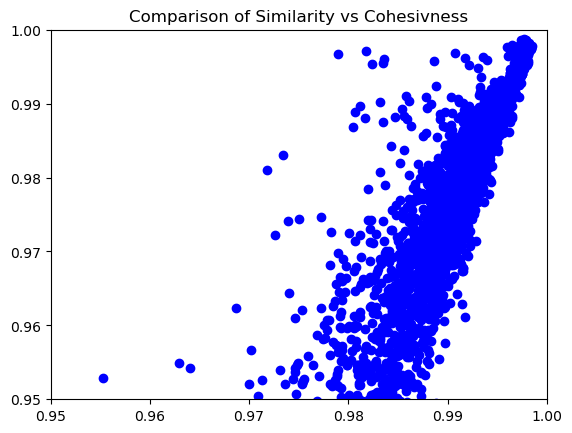

In [128]:
plt.scatter(corv,coh, color='blue')
plt.title('Comparison of Similarity vs Cohesivness')
plt.xlim(0.95,1)
plt.ylim(0.95,1)
plt.show()

A clear pattern exists!

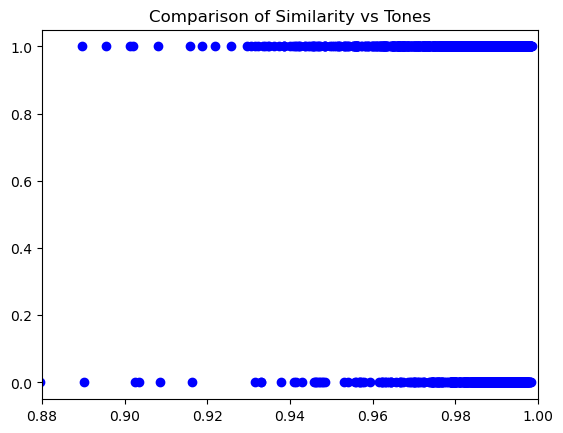

In [129]:
plt.scatter(corv,tones, color='blue')
plt.title('Comparison of Similarity vs Tones')
plt.xlim(0.88,1)
plt.show()

A likely pattern exists.

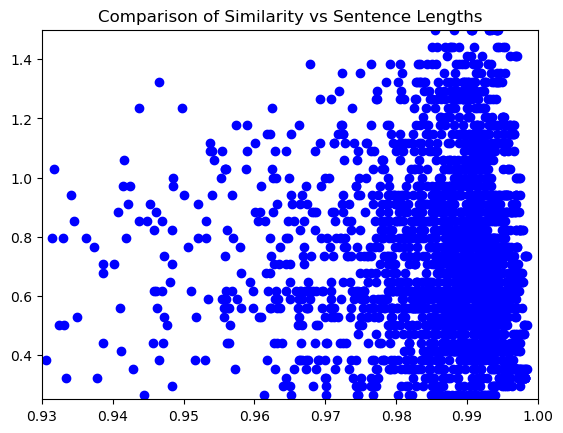

In [132]:
plt.scatter(corv,sentencelengths, color='blue')
plt.title('Comparison of Similarity vs Sentence Lengths')
plt.xlim(0.93,1)
plt.ylim(0.25, 1.5)
plt.show()

Finally, we go through all sentences and show if they are low or high in each attribute.

In [146]:
for i in range(689*4):
    vector=[0,0,0,0]
    print(pd.concat([df1,df2,df3,df5])['Sentences'][i])
    c = corv[i]
    if c>mcorv:
        vector[0]=1
    cc = coh[i]
    if cc>mcoh:
        vector[1]=1
    vector[2] = tones[i]
    sl2 = sentencelengths[i]
    if sl2>msl:
        vector[3]=1
    print(vector)

0    UN Humanitarian Chief Mark Lowcock today relea...
0    UN Humanitarian Chief Mark Lowcock today relea...
0    UN Humanitarian Chief Mark Lowcock today relea...
0    UN Humanitarian Chief Mark Lowcock today relea...
Name: Sentences, dtype: object
[1, 1, 1, 1]
1    The announcement came as the World Health Orga...
1    The announcement came as the World Health Orga...
1    The announcement came as the World Health Orga...
1    The announcement came as the World Health Orga...
Name: Sentences, dtype: object
[0, 0, 0, 1]
2    The WHO has said there is still a chance of co...
2    The WHO has said there is still a chance of co...
2    The WHO has said there is still a chance of co...
2    The WHO has said there is still a chance of co...
Name: Sentences, dtype: object
[0, 0, 1, 1]
3    There are now cases linked to Iran in Bahrain,...
3    There are now cases linked to Iran in Bahrain,...
3    There are now cases linked to Iran in Bahrain,...
3    There are now cases linked to Iran in 

KeyError: 689

In [149]:
vectors=[]
for i in range(689*4):
    vector=[0,0,0,0]
    c = corv[i]
    if c>mcorv:
        vector[0]=1
    cc = coh[i]
    if cc>mcoh:
        vector[1]=1
    vector[2] = tones[i]
    sl2 = sentencelengths[i]
    if sl2>msl:
        vector[3]=1
    vectors.append(tuple(vector))
print("[0,0,0,0]:", vectors.count((0,0,0,0)))
print("[0,0,0,1]:", vectors.count((0,0,0,1)))
print("[0,0,1,0]:", vectors.count((0,0,1,0)))
print("[0,0,1,1]:", vectors.count((0,0,1,1)))
print("[0,1,0,0]:", vectors.count((0,1,0,0)))
print("[0,1,0,1]:", vectors.count((0,1,0,1)))
print("[0,1,1,0]:", vectors.count((0,1,1,0)))
print("[0,1,1,1]:", vectors.count((0,1,1,1)))
print("[1,0,0,0]:", vectors.count((1,0,0,0)))
print("[1,0,0,1]:", vectors.count((1,0,0,1)))
print("[1,0,1,0]:", vectors.count((1,0,1,0)))
print("[1,0,1,1]:", vectors.count((1,0,1,1)))
print("[1,1,0,0]:", vectors.count((1,1,0,0)))
print("[1,1,0,1]:", vectors.count((1,1,0,1)))
print("[1,1,1,0]:", vectors.count((1,1,1,0)))
print("[1,1,1,1]:", vectors.count((1,1,1,1)))

[0,0,0,0]: 201
[0,0,0,1]: 87
[0,0,1,0]: 409
[0,0,1,1]: 518
[0,1,0,0]: 33
[0,1,0,1]: 7
[0,1,1,0]: 70
[0,1,1,1]: 53
[1,0,0,0]: 49
[1,0,0,1]: 11
[1,0,1,0]: 35
[1,0,1,1]: 68
[1,1,0,0]: 229
[1,1,0,1]: 83
[1,1,1,0]: 416
[1,1,1,1]: 487


These are the sixteen categories: e.g. "Low Similarity, Low Cohesiveness, High Tone, High Sentence Length." This is the most common with 518 instances.

Onto Task B. Here we will do some Named Entity Recognition on all words that begin with a capital letter and attempt to classify each as one of six categories: Name (person), Org (anization), Acronym, Place, Other, and Part of Longer String (e.g. a first name followed by a last name)

In [133]:
def capitalized(string):
    return ord(string[0]) in range(65,91)
    

In [140]:
def classify_propernoun(string,listofwords,mod):
    for item in listofwords:
        if len(item)==0:
            listofwords.remove(item)
    poss = ['NAME','ORG','ACRONYM','PLACE','OTHER','PARTOFLONGERSTRING']
    v=[]
    examples=['Tedros','Board','Temporary','Spain'] #Impartial examples of a name, an org, an "other", and a place
    i = listofwords.index(string)
    if string.isupper(): #acronyms are all caps
        v.append('ACRONYM')
    if i<len(listofwords)-1:
        if capitalized(listofwords[i+1]): #immediately followed by another capitalized word, it is probably linked
            v.append('PARTOFLONGERSTRING')
    beep = [similarity_check(mod,string,examples[e]) for e in range(0,4)]+[0,0]
    if i<len(listofwords)-1:
        if listofwords[i+1].endswith('s'): #a proper noun or verb most likely follows a person
            beep[0]+=0.02
            beep[1]+=0.008
            beep[2]+0.008
    if i>0:
        if listofwords[i-1]=="the": #you do not put "The" before a person's name or a place, but you do before an organization
            beep[0]-=0.4
            beep[1]+=0.2
            beep[3]-=0.4
        if listofwords[i-1]=="of": #often appears uncapitalized in organization name, like "Department of Transportation"
            beep[1]+=0.4
    if 'ACRONYM' in v:
        beep[4]=1
    if 'PARTOFLONGERSTRING' in v:
        beep[5]=1
    if i==0: #Anything could be capitalized if it is the first word of the sentence.
        beep[2]+=0.5
    if i>1: #last name
        if capitalized(listofwords[i-1]):
            if not capitalized(listofwords[i-2]):
                beep[0]+=0.08
    return beep
    #The returned 6-entry list shows the relative weight of the "Name", "Org", "Other", "Place", "Acronym", and "Part of Longer String"
    
        
    

This is an imperfect example. It actually classifies Committee as a place, but there are many other ways to consider it.

In [141]:
classify_propernoun('Committee',['The','Emergency','Committee','on','COVID-19'],model1)

[0.98977256, 0.9959493, 0.9795399, 0.9983031, 0, 0]

Let's run through all of test1 and check the likeliest type of each capital letter

In [143]:
for item in test1:
    for word in item:
        if len(word)==0:
            continue
        if capitalized(word):
            print(word)
            b = classify_propernoun(word, item, model1)
            print(b)
            if b[0]==max(b):
                print("NAME")
            if b[1]==max(b):
                print("ORG")
            if b[2]==max(b):
                print("OTHER")
            if b[3]==max(b):
                print("PLACE")
            if b[4]==max(b):
                print("ACRONYM")
            if b[5]==max(b):
                print("PARTOFLONGERSTRING")

UN
[0.988732, 0.9940181, 1.4806573390960693, 0.99646485, 1, 1]
OTHER
Humanitarian
[0.96306515, 0.9783235, 0.944136, 0.976133, 0, 1]
PARTOFLONGERSTRING
Chief
[0.9906947, 0.99412894, 0.9779006, 0.9972736, 0, 1]
PARTOFLONGERSTRING
Mark
[0.9788426, 0.9824768, 0.95664585, 0.98593324, 0, 1]
PARTOFLONGERSTRING
Lowcock
[0.97755414, 0.9817769, 0.96983564, 0.98745143, 0, 0]
PLACE
US15
[0.95902115, 0.9657771, 0.94744253, 0.96526456, 1, 0]
ACRONYM
Central
[0.5831392168998718, 1.190462601184845, 0.970966, 0.5928677082061767, 0, 1]
ORG
Emergency
[1.0682153868675233, 0.99363315, 0.9776603, 0.9954689, 0, 1]
NAME
Response
[0.9881478, 0.9935761, 0.975858, 0.99753284, 0, 1]
PARTOFLONGERSTRING
Fund
[0.97892064, 0.987198, 0.9692326, 0.98891985, 0, 1]
PARTOFLONGERSTRING
CERF
[0.92645717, 0.936262, 0.9122443, 0.9346561, 1, 0]
ACRONYM
COVID-19
[0.6095011186599731, 1.2028315024375915, 0.9806742, 0.5984405040740967, 1, 0]
ORG
The
[0.99145174, 0.9954006, 1.4794703722000122, 0.99863815, 0, 0]
OTHER
World
[0.57800

Sometimes this works, sometimes not. Further improvements include changing the isupper() function to consider nonalphabetic characters (like in COVID-19),
considering punctiation, and tweaking the offsets in the classify_propernoun function.

See the attached text file for Task 3 and further details.